In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd
import matplotlib
from matplotlib import gridspec
import matplotlib.ticker as ticker
from scipy.signal import find_peaks

# Import data

In [3]:
skeleton_folder_path = "E:/videos/filtered_skeleton/"

In [4]:
#csv files of filtered skeleton length generated by DLC, which are created from result of tracked points filtered by a median filter of window length 11
#file #0-5 are the tracking results of 6 different animals on 50% (0.7% agarose) plate, file #6-11 are the tracking results of the same six animals on 100% (1.5% agarose plate)
skeleton_paths = [
 '2(10)-780-1100(50)DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '3(11)-1950-2450(50)DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '4(12)-2050-2350(50)DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '5(13)-400-1000(50)DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '6(14)-350-700(50)DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '8(0401-7)-2100-2650(50)DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '2(10)-3200-3500DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '3(11-2)-250-1160DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '4(12)-780-1150DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '5(13)-1-600DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '6(14)-1350-1940DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv',
 '8(0401-7)-1250-1650DLC_resnet_50_lt-100framesApr7shuffle1_600000_filtered_skeleton.csv']

In [5]:
#unhooking moments from manual annotations
unhooking_moments = [[27, 93, 162, 244],
 [34, 120, 207, 311, 390],
 [55, 164, 272],
 [61, 205, 328, 439],
 [68, 144, 211],
 [88, 176, 270, 385],
 [79, 202, 283],
 [233, 349, 486, 624, 762, 900],
 [39, 169, 277, 365],
 [101, 201, 299, 412],
 [102, 237, 320, 444],
 [88, 169, 260, 341]]

In [6]:
#all skeleton parts
#LT4->LT2_a7, LT3->LT2_a6, LT2->LT2_a5,#LT1->LT2_a4
c_labels = [
 'VL-a8p_VL-a87',
 'VL-a87_VL-a76',
 'VL-a76_VL-a65',
 'VL-a65_VL-a54',
 'VL-a54_VL-a43',
 'VL-a43_VL-a32',
 'VL-a32_VL-a21',
 'VL-a21_VL-a1t3',
 'VL-a1t3_VL-t32',
 'VL-t32_VL-t21',
 'VL-t21_VL-t1a',
 'DL-a8p_DL-a87',
 'DL-a87_DL-a76',
 'DL-a76_DL-a65',
 'DL-a65_DL-a54',
 'DL-a54_DL-a43',
 'DL-a43_DL-a32',
 'DL-a32_DL-a21',
 'DL-a21_DL-a1t3',
 'DL-a1t3_DL-t32',
 'DL-t32_DL-t21',
 'LT4-v_LT4-d',
 'LT3-v_LT3-d',
 'LT2-v_LT2-d',
 'LT1-v_LT1-d']


In [7]:
#import the data of one bodypart/skeleton as a numpy masked array, data with likelihood smaller than 0.8 or strange orientations for LT muscles will be masked as False 
def get_cutoff_csv(Dataframe, bodypart, pcutoff=0.8,kw = 'length',o_flag=False):
    prob = np.array([float(i) for i in Dataframe[bodypart+'.2'][1:]])
    orie = np.array([float(i) for i in Dataframe[bodypart+'.1'][1:]])
    mask1 = prob < pcutoff
    mask2 = abs(orie-90) > 20
    if bodypart[0:2] == 'LT':
        o_flag = True
    if o_flag == True:
        temp_length = np.ma.array([float(i) for i in Dataframe[bodypart][1:]], mask=mask1 | mask2, fill_value = 999999)
    else:
        temp_length = np.ma.array([float(i) for i in Dataframe[bodypart][1:]], mask=mask1, fill_value = 999999)
    return(temp_length)

In [8]:
#import the data of one csv file by the name of the bodypart/skeleton  
def get_csv_length(path,skeleton_names):
    Dataframe = pd.read_csv(path)
    length_dict = {}
    for i in skeleton_names:
        length_dict[i] = get_cutoff_csv(Dataframe,i)
    return(length_dict)

In [9]:
#median filter
def nan_median(arr,s=5):
    k = s//2
    arr_medianed = np.empty(arr.shape[0])
    for n,i in enumerate(arr):
        if n<k or n+k>arr_medianed.shape[0]:
            arr_medianed[n] = np.nan
        else:
            arr_medianed[n] = np.nanmedian(arr[n-k:n+k])
    return(arr_medianed)

In [10]:
#import the muscle lengths of each strides
lengths_strides = []
"""
lengths_strides: n * m * k lists of numpy arrays of the tracked muscle lengths
n: number of videos (n=12)
m: number of strides (m in [2,3,4,5] )
k: number of skeleton parts arranged as c_labels
numpy array: skeleton length during a stride with leading 10 frames and following 10 frames [unhooking moment(n) - 10, unhooking moment(n+1) + 10]
"""
for path,um in zip(skeleton_paths,unhooking_moments):
    length = get_csv_length(os.path.join(skeleton_folder_path, path), c_labels)
    length_stride = []
    #medianed filtered, windowlength=5
    for key in length:
        length[key] = nan_median(length[key],5)
    for u1,u2 in zip(um[:-1],um[1:]):
        s = []
        for l in c_labels:
            s.append(length[l][u1-1-10:u2-1+10])
        length_stride.append(s[:])
    lengths_strides.append(length_stride[:])

C:\Users\liu_y\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\liu_y\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Warning: converting a masked element to nan.
  if __name__ == '__main__':


# Find the key time points 

In [11]:
#find the argument of the element of arr[x1:x2] that is nearest to the value y. 
def find_nearest(arr,y,x1,x2):
    return(np.nanargmin(np.abs(arr[x1:x2] - (np.zeros(x2-x1)+y)))+x1)

In [12]:
#calculate(c-d)*ratio+d, c-(c-d)*ratio
def cal_levels(a,b,ratio=0.2):
    c, d = np.amax([a,b]),np.amin([a,b])
    if np.isnan(c) or np.isnan(d):
        return(0,0)
    else:
        return((c-d)*ratio+d, c-(c-d)*ratio)

In [13]:
#find the most prominent peak in the data
def most_prom_peak(data):
    peaks, _ = find_peaks(data,prominence=0.1)
    return(peaks[_['prominences'].argmax()])

In [14]:
%matplotlib qt

-----
22 25 25 27 32
--------------
-----
13 18 25 30 36
--------------
-----
6 20 29 36 42
--------------
-----
14 28 36 40 47
--------------
-----
19 35 43 48 54
--------------
50
50
65
58
66
---------
-----
-3 7 15 20 31
--------------
-----
1 15 24 28 35
--------------
-----
10 21 29 36 46
--------------
-----
14 27 38 42 47
--------------
-----
20 35 42 49 54
--------------
51
57
68
66
70
---------
-----
1 13 20 26 36
--------------
-----
6 23 29 36 43
--------------
-----
14 30 41 45 54
--------------
-----
21 36 43 50 59
--------------
-----
27 44 50 58 66
--------------
64
64
75
86
84
---------


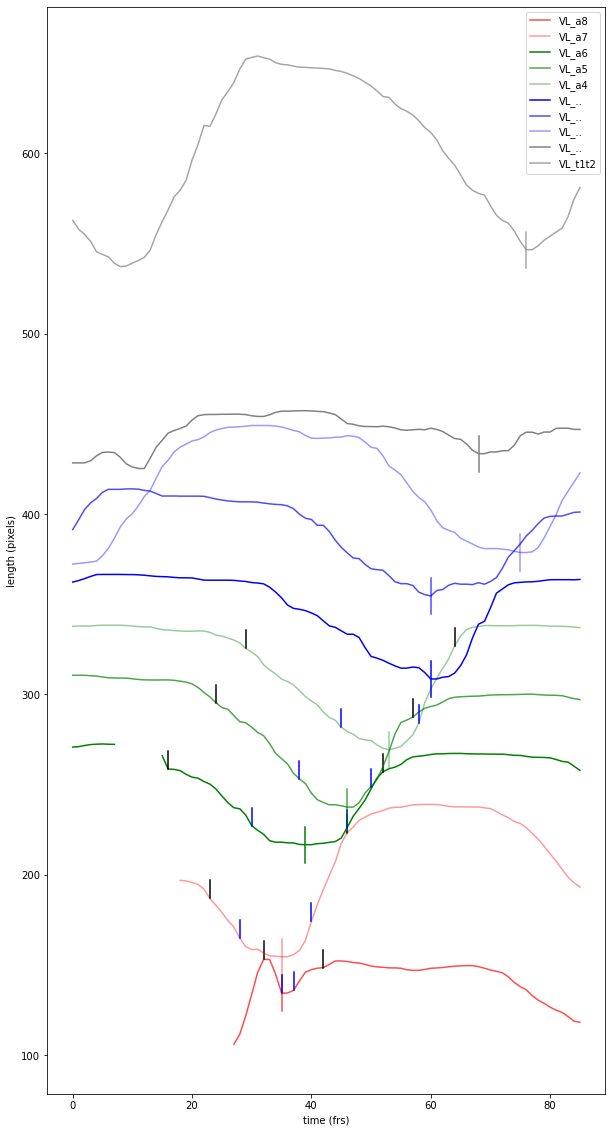

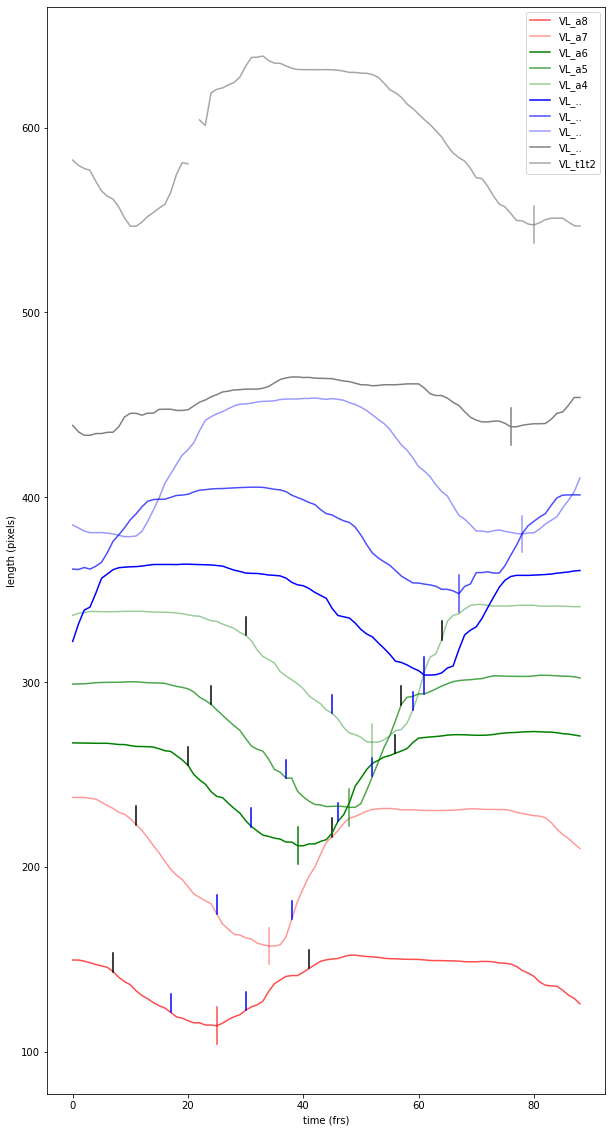

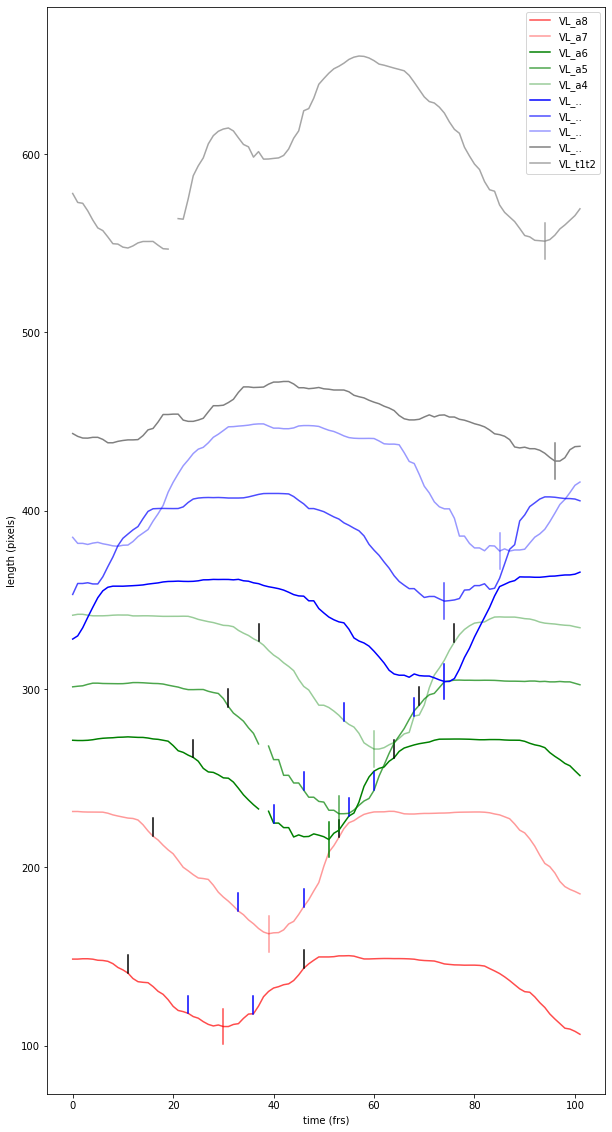

In [21]:
#annotate at different states of VL muscles to determine the phase ([contract_init, contract_end, valley, relax_init, relax_end])
f_n = 0
color = ['r','g','b','grey']
m = [1,0.7,0.4]
video_n = 0
dd=0
for arr in lengths_strides[video_n]:
    f_n = f_n+1
    plt.figure(f_n,figsize=(10,20))
    k = 0
    for n,i in enumerate(arr):
        if n<5:
            #VL_a8, VL_a7, VL_a6, VL_a5, VL_a4
            k = k+1
            plt.plot(i+40*k,color=color[k//3],alpha=m[k%3])
            #annotate valley
            valley = most_prom_peak(-i[:-30])
            plt.plot([valley,valley],[i[valley]+40*k-10,i[valley]+40*k+10],color=color[k//3],alpha=m[k%3],label='VL_a'+str(8-n))
            #annotate 20% and 80% contraction
            peak_left = np.nanargmax(i[:valley])
            a1,b1 = cal_levels(i[valley],i[peak_left],0.2)
            c1,d1 = find_nearest(i,a1,peak_left,valley+1),find_nearest(i,b1,peak_left,valley+1)
            plt.plot([c1,c1],[i[c1]+40*k,i[c1]+40*k+10],color='b')
            plt.plot([d1,d1],[i[d1]+40*k,i[d1]+40*k+10],color='k')
            print('-----')
            #annotate 20% and 80% relaxation
            peak_right = np.nanargmax(i[valley:])+valley
            a2,b2 = cal_levels(i[valley],i[peak_right],0.2)
            c2,d2 = find_nearest(i,a2,valley,peak_right+1),find_nearest(i,b2,valley,peak_right+1)
            plt.plot([c2,c2],[i[c2]+40*k,i[c2]+40*k+10],color='b')
            plt.plot([d2,d2],[i[d2]+40*k,i[d2]+40*k+10],color='k')
            print(d1-10,c1-10,valley-10,c2-10,d2-10)
            print('--------------')
        if n>=5 and n<9:
            k = k+1
            plt.plot(i+40*k,color=color[k//3],alpha=m[k%3])
            #annotate valley
            valley = most_prom_peak(-i[20:])+20
            plt.plot([valley,valley],[i[valley]+40*k-10,i[valley]+40*k+10],color=color[k//3],alpha=m[k%3], label='VL_..')
            print(valley-10)
        if n==9:
            k=k+1
            ii = arr[n+1]+i
            plt.plot(ii+40*k,color=color[k//3],alpha=m[k%3])
            #annotate valley
            valley = most_prom_peak(-ii[35:]) + 35
            plt.plot([valley,valley],[ii[valley]+40*k-10,ii[valley]+40*k+10],color=color[k//3],alpha=m[k%3],label='VL_t1t2')
            print(valley-10)
            print('---------')
        plt.legend()
        plt.xlabel('time (frs)')
        plt.ylabel('length (pixels)')

-----
10 15 18 28 31 41
--------------
-----
10 15 17 31 40 47
--------------
-----
14 22 25 40 44 56
--------------


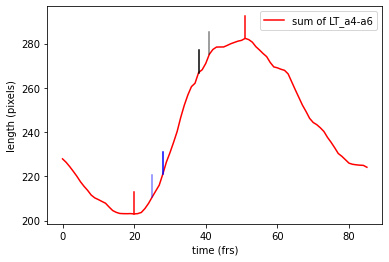

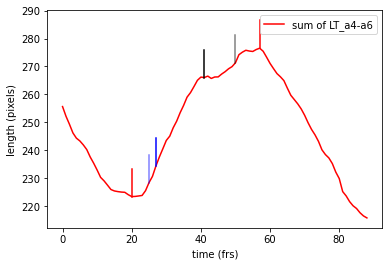

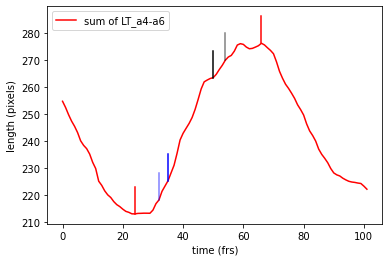

In [24]:
#annotate the 10%, 20% and 80%, 90% of the relaxation of LT muscles
color = ['r','g','b','grey']
m = [1,0.7,0.4]
dd = 0
for arr in lengths_strides[video_n]:
    f_n = f_n+1
    plt.figure(f_n)
    k = 0
    #sum of LT2_a6, LT2_a5, LT2_a4
    iii = arr[-3] + arr[-2] + arr[-1]
    plt.plot(iii,color=color[k//3],alpha=m[k%3],label='sum of LT_a4-a6')
    #find valleys and peaks
    valley = most_prom_peak(-iii[:-20])
    peak = most_prom_peak(iii[:-10])
    plt.plot([peak,peak],[iii[peak],iii[peak]+10],color=color[k//3],alpha=m[k%3])
    plt.plot([valley,valley],[iii[valley],iii[valley]+10],color=color[k//3],alpha=m[k%3])
    #find 20% and 80% relaxation
    a1,b1 = cal_levels(iii[peak],iii[valley],0.2)
    c1,d1 = find_nearest(iii,a1,valley,peak),find_nearest(iii,b1,valley,peak)
    plt.plot([c1,c1],[iii[c1],iii[c1]+10],color='b')
    plt.plot([d1,d1],[iii[d1],iii[d1]+10],color='k')
    #find 10% and 90% relaxation
    a2,b2 = cal_levels(iii[peak],iii[valley],0.1)
    c2,d2 = find_nearest(iii,a2,valley,peak),find_nearest(iii,b2,valley,peak)
    plt.plot([c2,c2],[iii[c2],iii[c2]+10],color='b',alpha=0.5)
    plt.plot([d2,d2],[iii[d2],iii[d2]+10],color='k',alpha=0.5)
    print('-----')
    print(valley-10,c2-10,c1-10,d1-10,d2-10,peak-10)
    print('--------------')
    plt.xlabel('time (frs)')
    plt.ylabel('length (pixels)')
    plt.legend()


# Some demo plot for aim 1

In [17]:
%matplotlib inline

In [19]:
#Frame numbers when VL_length is at the valley. Previously annotated from video #0 to video #5 with valid values of v_valley from VL_a7 to VL_t1. 
#v_valleys is organized as [v_valley_a8, ..., v_valley_t3, v_valley_t2t1]
#v_valley at VL_a7 is manually annotated at the initiation of the relaxation
v_valleys = np.array([[ np.nan,  25.,  28.,  35.,  45.,  54.,  61.,  64.,  58.,  66.],
        [ np.nan,  32.,  43.,  48.,  62.,  72.,  77.,  85.,  85.,  39.],
        [ 62.,  66.,  69.,  77.,  81.,  93.,  92., 104., 106., 117.],
        [ 29.,  35.,  41.,  48.,  51.,  54.,  62.,  76.,  70.,  76.],
        [ 13.,  23.,  31.,  38.,  44.,  54.,  56.,  67.,  69.,  71.],
        [ 30.,  36.,  40.,  52.,  60.,  72.,  74.,  90.,  88.,  76.],
        [ 32.,  22.,  33.,  38.,  43.,  48.,  53.,  59.,  66.,  63.],
        [ 20.,  40.,  47.,  54.,  61.,  72.,  78.,  84.,  97.,  86.],
        [ 21.,  28.,  37.,  42.,  50.,  59.,  68.,  76.,  87.,  89.],
        [ 45.,  49.,  62.,  67.,  76.,  81.,  89.,  98.,  99.,  61.],
        [ 61.,  64.,  66.,  74.,  80.,  93., 101., 109., 119.,  np.nan],
        [ 57.,  49.,  59.,  64.,  72.,  88.,  81., 104., 106., 122.],
        [ 14.,  27.,  32.,  48.,  56.,  66.,  70.,  76.,  79.,  63.],])

In [20]:
#Frame numbers when LT2_length is at the 20per and 80per during the relaxation.
lt_20_and_80_relax = np.array([[26., 37.],
       [33., 55.],
       [57., 70.],
       [35., 46.],
       [25., 39.],
       [39., 56.],
       [32., 39.],
       [38., 55.],
       [33., 52.],
       [45., 67.],
       [53., 73.],
       [49., 65.],
       [35., 55.]])

In [21]:
#calculate the phase by the nearest VL_valleys
def cal_phase(t,refs):
    if t >= refs[0] and t < refs[-1]:
        for n,k in enumerate(t-refs):
            if k<0:
                ref1 = refs[n-1]
                ref2 = refs[n]
                break
        phase = (t-ref1)/(ref2-ref1) + n-1
    elif t < refs[0]:
        phase = -(t-refs[0])/(refs[0]-refs[-1])*4
    return(phase)

In [22]:
phase_ref = v_valleys[:,1:6]

In [23]:
relax_20_80_phase=[]
for i,j in zip(lt_20_and_80_relax,phase_ref):
    relax_20_80_phase.append([cal_phase(i[0],j),cal_phase(i[1],j)])

In [24]:
relax_20_80_phase = sorted(relax_20_80_phase)

Text(0.5, 1.0, 'relaxation of LT muscles')

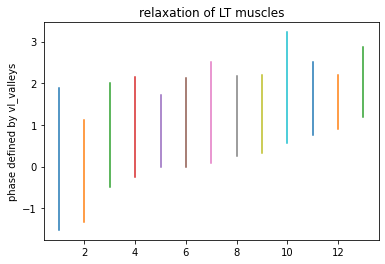

In [25]:
#y = 0: VL_a7 valley just before relaxation. y = 1: VL_a6 valley, ... ,
#x: strides #1, #2
#lines: From 20% relaxation of LT muscles to 80% relaxation
k=0
for i in relax_20_80_phase:
    k=k+1
    plt.plot([k,k],[i[0],i[1]])
plt.ylabel("phase defined by vl_valleys")
plt.title("relaxation of LT muscles")

In [26]:
a7_init = phase_ref[:,0] - 10

In [27]:
lt_relax_init = lt_20_and_80_relax[:,0]-10

Text(0, 0.5, 't_VL_a7_valley - t_unhooking (s)')

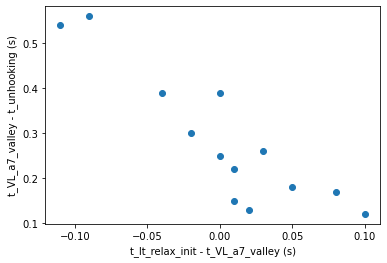

In [28]:
plt.scatter((lt_relax_init-a7_init)/100, a7_init/100)
plt.xlabel("t_lt_relax_init - t_VL_a7_valley (s)")
plt.ylabel("t_VL_a7_valley - t_unhooking (s)")

# Other functions might be useful

In [4]:
#Posterior skeleton parts
skeleton_V = [
  'VL-a87_VL-a76',
  'VL-a76_VL-a65',
  'VL-a65_VL-a54',
  'VL-a54_VL-a43']
skeleton_D = [
  'DL-a87_DL-a76',
  'DL-a76_DL-a65',
  'DL-a65_DL-a54',
  'DL-a54_DL-a43']
skeleton_L = [
  'LT4-v_LT4-d',
  'LT3-v_LT3-d',
  'LT2-v_LT2-d',
  'LT1-v_LT1-d'] #LT4->LT2_a7, LT3->LT2_a6, LT2->LT2_a5,#LT1->LT2_a4

In [8]:
def plot_csv_mixed(folder_path, paths):
    matplotlib.rc('xtick', labelsize=20) 
    matplotlib.rc('ytick', labelsize=20) 
    for n, path in enumerate(paths):
        Dataframe = pd.read_csv(folder_path + path)
        fig = plt.figure(figsize = (5,20))
        gs = gridspec.GridSpec(len(skeleton_L), 1, height_ratios=[1] * len(skeleton_L)) 
        axs = []
        for num in range(len(skeleton_L)):
            nn = len(skeleton_L) - 1
            tmp1 = get_cutoff_csv(Dataframe,skeleton_L[nn-num])
            tmp2 = get_cutoff_csv(Dataframe,skeleton_D[nn-num])
            tmp3 = get_cutoff_csv(Dataframe,skeleton_V[nn-num])
            if num == 0:
                ax0 = plt.subplot(gs[num])
                ax0.plot(tmp1,color = 'c')
                ax0.plot(tmp2,color = 'm')
                ax0.plot(tmp3, color = 'g')
                ax0.xaxis.set_major_locator(ticker.NullLocator())
                ax0.set_ylim(50,200)
            elif num != len(skeleton_L)-1:
                ax1 =  plt.subplot(gs[num])
                ax1.plot(tmp1,color = 'c')
                ax1.plot(tmp2,color = 'm')
                ax1.plot(tmp3, color = 'g')
                plt.setp(ax0.get_xticklabels(), visible=False)
                ax1.xaxis.set_major_locator(ticker.NullLocator())
                ax1.set_ylim(50,200)
            else:
                axn =  plt.subplot(gs[num])
                axn.plot(tmp1,color = 'c')
                axn.plot(tmp2,color = 'm')
                axn.plot(tmp3,color = 'g')
                axn.set_xlabel('time (frs)')
                axn.set_ylabel('length (pxs)')
                plt.setp(ax0.get_xticklabels(), visible=False)
                axn.set_ylim(50,200)
        plt.subplots_adjust(hspace=.0)
        plt.show()

In [9]:
%matplotlib qt

In [10]:
#example plot of the posterior skeleton parts 
plot_csv_mixed(skeleton_folder_path, skeleton_paths)

In [16]:
def cal_speed(lengths, interval):
    k = interval//2
    speed = np.empty(lengths.shape[0])
    lengths = nan_median(lengths)
    for n in range(lengths.shape[0]):
        if n>k-1 and n<lengths.shape[0]-k-1:
            speed[n] = lengths[n+k]-lengths[n-k]
        else:
            speed[n] = np.nan
    return(speed)

In [17]:
#calculate speed at frame n by length[n+interval//2] -length[n-interval//2]
def get_csv_speed(path, skeleton_names, interval=5):
    Dataframe = pd.read_csv(path)
    speed_dict = {}
    for i in skeleton_names:
        speed_dict[i] = cal_speed(get_cutoff_csv(Dataframe,i),interval)
    return(speed_dict)

In [281]:
#speed of muscle length change of each stride
speeds_strides = []
"""
speeds_strides: n * m * k lists of numpy arrays of the tracked muscle speeds
n: number of videos (n=12)
m: number of strides (m in [2,3,4,5] )
k: number of skeleton parts arranged as c_labels
numpy array: skeleton speed of time [unhooking moment(n) - 10, unhooking moment(n+1) +10]
"""
for path,um in zip(skeleton_paths,unhooking_moments):
    speed = get_csv_speed(skeleton_folder_path+path, c_labels)
    speed_stride = []
    for u1,u2 in zip(um[:-1],um[1:]):
        s = []
        for l in c_labels:
            s.append(speed[l][u1-1-10:u2-1+10])
        speed_stride.append(s[:])
    speeds_strides.append(speed_stride[:])

/home/yingtao/anaconda3/envs/caiman/lib/python3.7/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/yingtao/anaconda3/envs/caiman/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Warning: converting a masked element to nan.
  
